In [1]:
from torch.utils.data import Dataset
import os
import tifffile as tiff
import numpy as np
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter

from scipy.stats import mode

In [43]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = []
        self.labels = []
        self.class_names = []  # To store class (folder) names
        self.class_to_idx = {}  # To map class names to indices
        self.class_counts = {}  # To store count of images per class

        # Define a transformation to resize the images
        self.transform = transforms.Compose([transforms.Resize((96, 96))])

        # Get all subdirectories (classes)
        self.class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
        self.class_names.sort()  # Ensure consistent ordering
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        # Load images and assign labels based on folder name
        for class_name in self.class_names:
            class_dir = os.path.join(image_dir, class_name)
            class_images = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
            self.image_files.extend(class_images)
            self.labels.extend([self.class_to_idx[class_name]] * len(class_images))  # Assign class index as label
            
            # Store the count of images per class
            self.class_counts[class_name] = len(class_images)

        # Print labels and counts
        self.print_labels_and_counts()
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]

        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)

        # Apply the resizing transform (resize)
        image = self.transform(image)

        flattened_image = image.view(-1).numpy()  # Reshape to (96*96*3, )
        
        return flattened_image, label 
        #return flattened_image, label, img_path

    def print_labels_and_counts(self):
        print("Class Labels and Counts:")
        for class_name, class_index in self.class_to_idx.items():
            print(f"Class '{class_name}' (Index {class_index}): {self.class_counts[class_name]} images")


# Example usage



#image_dir = r"G:\cluster_40\cure"
#image_dir = r"G:\cluster_40\uncure"
#image_dir=  r"G:\classification\cond_all"
image_dir=  r"G:\classification\cure_cond" 


dataset = ImageDataset(image_dir)  # Initialize dataset, it will automatically print labels and counts


Class Labels and Counts:
Class 'cond7_curated' (Index 0): 280 images
Class 'ex' (Index 1): 40 images
Class 'sd' (Index 2): 103 images


In [44]:
for i in range(len(dataset)):
    flattened_image,label = dataset[i]
    print(flattened_image.shape)
    #print(f"File Path: {img_path}")
    print(f"Label: {label}")
    print(f"Flattened Image Shape: {flattened_image.shape}")  # This will print the shape of each image
    break

(27648,)
Label: 0
Flattened Image Shape: (27648,)


In [45]:
from sklearn.preprocessing import normalize
# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []
   
    
    for i in range(len(dataset)):
        
        flattened_image, label = dataset[i]
        all_images.append(flattened_image)
        all_labels.append(label)
        
    
    # Stack all the flattened images to create a large dataset
    X = np.vstack(all_images)  # Combine all images into a single dataset

    # Normalize the combined dataset along the features axis (axis=1)
    X_normalized = normalize(X, axis=1)
  
    return X_normalized, np.array(all_labels)

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]  # Randomly select K centroids from normalized X
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # No need to normalize X and centroids here as they are already normalized
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        similarities = np.dot(centroids, X[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids_norm = normalize(centroids, axis=1)
    return centroids_norm

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, filepaths, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])

    for i in range(max_iters):
      
        
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function
        sim = np.dot(X, centroids.T)
        cosine_dist = 1 - sim

        cost = np.sum(cosine_dist)
    return centroids, idx


In [60]:

X, labels = load_image_data(dataset) 
    

K = 3                          # Step 2: Set number of clusters
initial_centroids = kMeans_init_centroids(X, K)  # Step 3: Initialize centroids 
max_iters = 100                # Step 4: Number of iterations


centroids, idx = run_kMeans(X, initial_centroids, max_iters)

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({2: 86, 0: 52, 1: 6})
Cluster 1 has true labels: Counter({0: 105, 1: 34, 2: 17})
Cluster 2 has true labels: Counter({0: 123})


In [57]:
124+88+34

246

In [53]:
246/423

0.5815602836879432

In [64]:
import torch
from sklearn.preprocessing import normalize
from scipy.stats import mode
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []

    for i in range(len(dataset)):
        flattened_image, label = dataset[i]
        all_images.append(flattened_image)
        all_labels.append(label)

    X = np.vstack(all_images)
    X_normalized = normalize(X, axis=1)
    return torch.tensor(X_normalized, dtype=torch.float32), torch.tensor(all_labels, dtype=torch.int64)

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = torch.randperm(X.shape[0], device=X.device)
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    similarities = torch.matmul(X, centroids.T)  # Compute cosine similarities
    idx = torch.argmax(similarities, dim=1)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = torch.zeros((K, X.shape[1]), device=X.device)
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = points.mean(dim=0)
    centroids = torch.nn.functional.normalize(centroids, dim=1)
    return centroids

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = torch.zeros(X.shape[0], dtype=torch.int64, device=X.device)

    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)

    return centroids, idx

# Function to reorder labels for accuracy computation
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = torch.zeros_like(predicted_labels)
    for cluster in torch.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        most_common_label = mode(true_labels[mask].cpu().numpy(), axis=None).mode
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]
        reordered_labels[mask] = most_common_label
    return reordered_labels

# Main loop to run K-Means multiple times and find the maximum accuracy
def evaluate_kMeans(dataset, K=3, max_iters=100, runs=100, device='cuda'):
    X, labels = load_image_data(dataset)
    X, labels = X.to(device), labels.to(device)
    max_accuracy = 0
    best_centroids = None
    best_idx = None

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        initial_centroids = kMeans_init_centroids(X, K)
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        reordered_idx = reorder_labels(labels, idx)
        accuracy = (reordered_idx == labels).float().mean().item() * 100
        print(f"Accuracy for run {run + 1}: {accuracy:.2f}%")

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_centroids = centroids.clone()
            best_idx = idx.clone()

    print(f"Maximum Accuracy Achieved: {max_accuracy:.2f}%")

    return max_accuracy, X.cpu().numpy(), labels.cpu().numpy(), best_idx.cpu().numpy(), best_centroids.cpu().numpy()

# Example call to the function
max_accuracy, X, labels, best_idx, best_centroids = evaluate_kMeans(dataset, K=3, max_iters=50, runs=100, device='cuda')


KeyboardInterrupt: 

Running t-SNE for visualization...


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


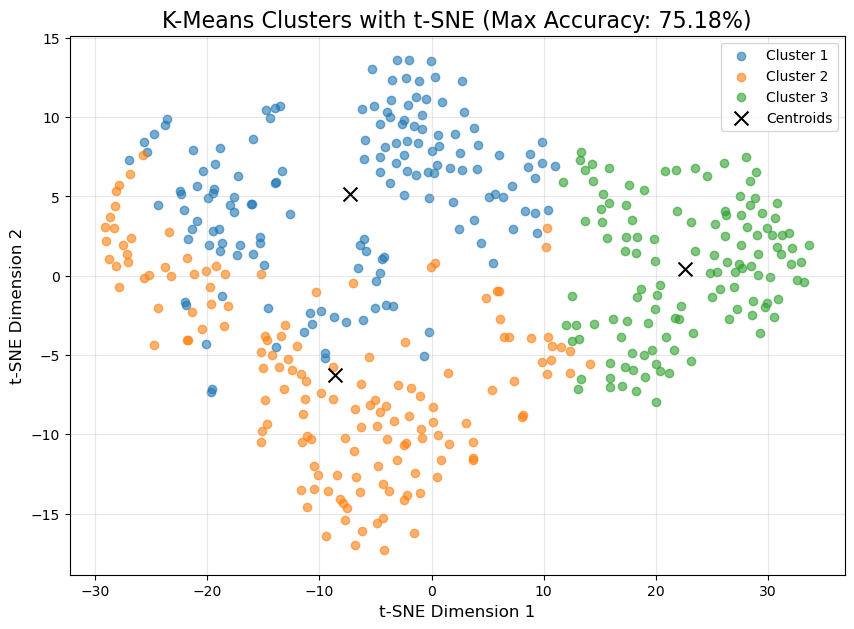

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_clusters_with_tsne(X, best_idx, K, max_accuracy):
    """
    Visualize clusters and centroids using t-SNE in 2D.

    Parameters:
    - X: Input features (original data).
    - best_idx: Cluster labels for each data point.
    - K: Number of clusters.
    - max_accuracy: Best clustering accuracy.
    """
    # Apply t-SNE to project data points to 2D
    print("Running t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(X)  # Project data to 2D

    # Compute centroids in the 2D t-SNE space
    centroids_2d = np.array([
        np.mean(features_2d[best_idx == cluster_id], axis=0)
        for cluster_id in range(K)
    ])

    # Create a scatter plot of the t-SNE-transformed features
    plt.figure(figsize=(10, 7))
    for cluster_id in range(K):
        cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id + 1}", alpha=0.6)

    # Plot the centroids
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], color="black", marker="x", s=100, label="Centroids")

    # Customize the plot
    plt.title(f"K-Means Clusters with t-SNE (Max Accuracy: {max_accuracy:.2f}%)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
plot_clusters_with_tsne(X, best_idx, 3, max_accuracy)


Running t-SNE for visualization...


c:\Users\k54739\.conda\envs\master\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


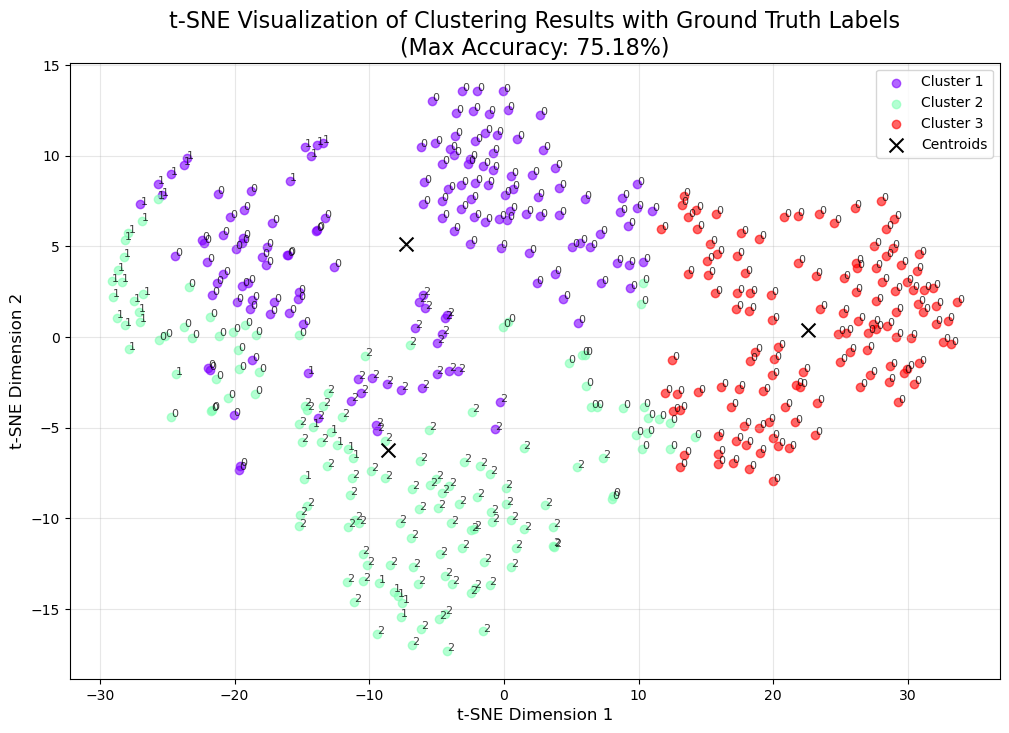

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_clusters_with_ground_truth(X, best_idx, labels_np, K, max_accuracy):
    """
    Visualize clusters and centroids using t-SNE in 2D, including ground truth labels for each data point.

    Parameters:
    - X: Input features (original data).
    - best_idx: Cluster labels for each data point.
    - labels_np: Ground truth labels for each data point.
    - K: Number of clusters.
    - max_accuracy: Best clustering accuracy.
    """
    # Apply t-SNE to project data points to 2D
    print("Running t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(X)  # Project data to 2D

    # Compute centroids in the 2D t-SNE space
    centroids_2d = np.array([
        np.mean(features_2d[best_idx == cluster_id], axis=0)
        for cluster_id in range(K)
    ])

    # Create a scatter plot of the t-SNE-transformed features
    plt.figure(figsize=(12, 8))

    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))

    # Plot each cluster with points and ground truth labels
    for cluster_id in range(K):
        cluster_points = features_2d[best_idx == cluster_id]  # Points in the current cluster
        cluster_labels = labels_np[best_idx == cluster_id]  # True labels for the current cluster

        # Scatter plot for cluster points
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=colors[cluster_id], alpha=0.6, label=f"Cluster {cluster_id + 1}")

        # Annotate each point with its true label
        for i, label in enumerate(cluster_labels):
            plt.annotate(str(label), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                color="black", marker="x", s=100, label="Centroids")

    # Customize the plot
    plt.title(f"t-SNE Visualization of Clustering Results with Ground Truth Labels\n(Max Accuracy: {max_accuracy:.2f}%)", fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
plot_clusters_with_ground_truth(X, best_idx, labels, 3, max_accuracy)


import torch
from sklearn.preprocessing import normalize
from scipy.stats import mode
import numpy as np

# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []

    for i in range(len(dataset)):
        flattened_image, label = dataset[i]
        all_images.append(flattened_image)
        all_labels.append(label)

    X = np.vstack(all_images)
    X_normalized = normalize(X, axis=1)
    return torch.tensor(X_normalized, dtype=torch.float32), torch.tensor(all_labels, dtype=torch.int64)

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = torch.randperm(X.shape[0], device=X.device)
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    similarities = torch.matmul(X, centroids.T)  # Compute cosine similarities
    idx = torch.argmax(similarities, dim=1)
    return idx

# Function to compute new centroids using scatter_add for efficiency
def compute_centroids(X, idx, K):
    centroids = torch.zeros((K, X.shape[1]), device=X.device)
    counts = torch.zeros(K, device=X.device)
    
    # Add all points belonging to each cluster
    centroids.scatter_add_(0, idx.unsqueeze(1).expand_as(X), X)
    
    # Count the number of points in each cluster
    counts.scatter_add_(0, idx, torch.ones_like(idx, dtype=torch.float32))
    
    # Avoid division by zero
    counts = counts.clamp_min(1.0)
    
    # Compute centroids by dividing summed points by the count
    centroids = centroids / counts.unsqueeze(1)
    centroids = F.normalize(centroids, p=2, dim=1)
    return centroids

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = torch.zeros(X.shape[0], dtype=torch.int64, device=X.device)

    with torch.no_grad():  # No gradient computation needed
        for _ in range(max_iters):
            idx = find_closest_centroids(X, centroids)
            centroids = compute_centroids(X, idx, K)

    return centroids, idx

# Function to reorder labels for accuracy computation
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = torch.zeros_like(predicted_labels)
    for cluster in torch.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        most_common_label = mode(true_labels[mask].cpu().numpy(), axis=None).mode
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]
        reordered_labels[mask] = most_common_label
    return reordered_labels

# Main loop to run K-Means multiple times and find the maximum accuracy
def evaluate_kMeans(dataset, K=3, max_iters=100, runs=100, device='cuda'):
    X, labels = load_image_data(dataset)
    X, labels = X.to(device), labels.to(device)
    max_accuracy = 0

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        initial_centroids = kMeans_init_centroids(X, K)
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        reordered_idx = reorder_labels(labels, idx)
        accuracy = (reordered_idx == labels).float().mean().item() * 100
        print(f"Accuracy for run {run + 1}: {accuracy:.2f}%")
        max_accuracy = max(max_accuracy, accuracy)

    print(f"Maximum Accuracy Achieved: {max_accuracy:.2f}%")
    return max_accuracy

# Example call to the function
# Ensure your GPU is enabled
max_accuracy = evaluate_kMeans(dataset, K=3, max_iters=50, runs=100, device='cuda')


# from scratch

In [34]:
from sklearn.preprocessing import normalize
# Combine all images into a single dataset for K-Means input
def load_image_data(dataset):
    all_images = []
    all_labels = []
    #all_filepaths = []
    
    for i in range(len(dataset)):
        #flattened_image, label, filepath = dataset[i]  # Unpack the image, label, and file path
        flattened_image, label = dataset[i]
        all_images.append(flattened_image)
        all_labels.append(label)
        #all_filepaths.append(filepath)
    
    # Stack all the flattened images to create a large dataset
    X = np.vstack(all_images)  # Combine all images into a single dataset

    # Normalize the combined dataset along the features axis (axis=1)
    X_normalized = normalize(X, axis=1)
    #return X_normalized, np.array(all_labels), all_filepaths
    return X_normalized, np.array(all_labels)

# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]  # Randomly select K centroids from normalized X
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # No need to normalize X and centroids here as they are already normalized
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        similarities = np.dot(centroids, X[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids_norm = normalize(centroids, axis=1)
    return centroids_norm

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, filepaths, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])

    for i in range(max_iters):
        #print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function
        sim = np.dot(X, centroids.T)
        cosine_dist = 1 - sim

        cost = np.sum(cosine_dist)
        #print(f"Cost function value: {cost}")
    
    # Validate input lengths
    #assert len(idx) == len(filepaths), "Mismatch: idx and filepaths must have the same length."
    
    # Validate cluster indices
    #assert set(idx).issubset(range(K)), "Error: idx contains invalid cluster indices."
    
    # Group filepaths by clusters
    #clustered_filepaths = {k: [] for k in range(K)}
    #for i, cluster_idx in enumerate(idx):
        #clustered_filepaths[cluster_idx].append(filepaths[i])
    
    # Check for empty clusters
    #for cluster in range(K):
        #if not clustered_filepaths[cluster]:
            #print(f"Warning: Cluster {cluster} has no images assigned.")
    
    #return centroids, idx, clustered_filepaths
    return centroids, idx


In [35]:
# Main function to run the K-Means algorithm
#X, labels, filepaths = load_image_data(dataset)  # Load data, labels, and filepaths 
X, labels = load_image_data(dataset) 
# To check and print the dimensions:
#print("Shape of stacked images (X):", X.shape)
#print("Shape of labels:", labels.shape)       

K = 3                          # Step 2: Set number of clusters
initial_centroids = kMeans_init_centroids(X, K)  # Step 3: Initialize centroids 
max_iters = 100                # Step 4: Number of iterations

#centroids, idx, clustered_filepaths = run_kMeans(X, initial_centroids, filepaths, max_iters)  # Step 5: Run K-Means
centroids, idx = run_kMeans(X, initial_centroids, max_iters)
# Print the file paths grouped by clusters and the total number of images in each cluster

'''
for cluster, paths in clustered_filepaths.items():
    print(f"Cluster {cluster}: Total images: {len(paths)}")
    for path in paths:
        print(f"  {path}")'''


# `idx` contains the cluster assignments from KMeans
#  `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({0: 255})
Cluster 1 has true labels: Counter({0: 88, 1: 33, 2: 21})
Cluster 2 has true labels: Counter({0: 129, 2: 82, 1: 7})


In [38]:
255+33+82

370

In [39]:
370/615

0.6016260162601627

In [36]:
# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels


In [37]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels) / len(labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 76.75%


print("Cluster assignments:", idx)
print("True labels:", labels)

print("Cluster assignments:", best_idx)
print("True labels:", labels)

Cluster 0 has true labels: Counter({2: 26, 1: 6})
Cluster 1 has true labels: Counter({1: 29, 0: 17, 2: 7})
Cluster 2 has true labels: Counter({0: 23, 2: 7, 1: 5})


Accuracy: 63.33%


K = len(np.unique(best_idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(best_idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

In [30]:
# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels


In [31]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels) / len(labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 65.00%


In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [41]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("2D Visualization of Clusters using PCA with True Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


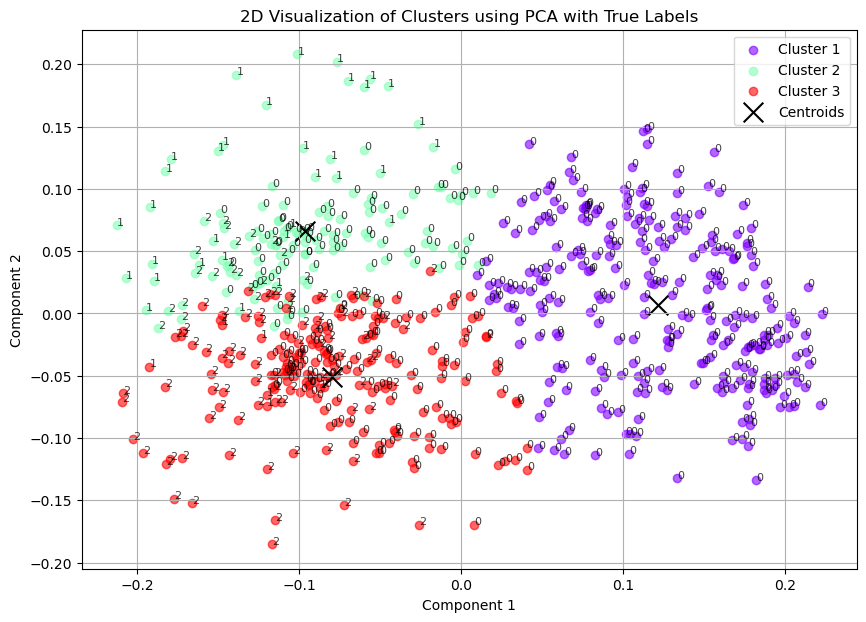

In [42]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(X, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels, K)


In [ ]:
total_data_points = 30+30+12
wrong = 3 
predicted_corrected = total_data_points - wrong
accuracy = (predicted_corrected/total_data_points)*100
print(accuracy)

In [19]:
bibi = np.array([
    [0.6394, 0.64353806, 0.64770716, 0.68035775, 0.68076485, 0.68122697],
    [0.6434593, 0.64427465, 0.6459859, 0.6629785, 0.6606025, 0.65433437],
    [0.6341258, 0.63328487, 0.62688166, 0.6681404, 0.66825783, 0.6676554],
    [0.627638, 0.6284246, 0.6292516, 0.61081785, 0.6114242, 0.6106233],
    [0.63396144, 0.63511825, 0.6288564, 0.6226765, 0.6219877, 0.62269145],
    [0.6106442, 0.61703616, 0.6183802, 0.616232, 0.6164079, 0.6152731],
    [0.6106442, 0.61703616, 0.6183802, 0.616232, 0.6164079, 0.6152731]
])

In [ ]:
bibi.shape[0]

In [21]:
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')] 
        
        # Define a transformation to resize the images
        self.transform = transforms.Compose([transforms.Resize((256, 256))])
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)

        # Apply the resizing transform
        image = self.transform(image)

        image_numpy = image.numpy()

        return image_numpy, original_image


In [ ]:
# Create dataset and visualize images
dataset = ImageDataset(r"../../tiff_experiment_unsupervised_data/combined")
for i in range(len(dataset)):
    image_numpy, original_image = dataset[i]  # This will get the resized and original images

    # Plot the original and resized images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    axes[0].imshow(original_image.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Turn off axis

    # Display resized image
    axes[1].imshow(image_numpy.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[1].set_title('Resized Image')
    axes[1].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

    break  

In [23]:
class ImageData(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')] 
        
        # Define a transformation to resize the images (Note: Resize expects a PIL image or torchvision tensor)
        self.transform = transforms.Resize((256, 256))
     
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Print the shape of the loaded image
        print(f"Image {img_path} loaded with shape: {image.shape}")

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        original_image = image.astype(np.float32) / 65535.0
        print(original_image.shape)
        # Convert to a torch tensor 
        image = torch.tensor(original_image, dtype=torch.float32)
        print(f"tensor image {image.shape}")
        # Apply resizing using torch.nn.functional.interpolate
        image = F.interpolate(image.unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0)

        image_numpy = image.numpy()

        # Flatten the resized image for K-Means input (reshape into (3, 256*256))
        #reshaped_image = image.view(3, -1).T  # Reshape to (256*256, 3)
        #print(f"Reshaped image shape: {reshaped_image.shape}")

        return original_image, image_numpy

In [ ]:
# Create dataset and visualize images
dataset = ImageData(r"../../tiff_experiment_unsupervised_data/combined")
for i in range(len(dataset)):
    orig_image, image_np = dataset[i]  # This will get the resized and original images

    # Plot the original and resized images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display original image
    axes[0].imshow(orig_image.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Turn off axis

    # Display resized image
    axes[1].imshow(image_np.transpose(1, 2, 0))  # Change shape for imshow (H, W, C)
    axes[1].set_title('Resized Image')
    axes[1].axis('off')  # Turn off axis

    plt.tight_layout()
    plt.show()

    break  

In [ ]:
image = tiff.imread(r'C:\Users\k54739\Bibin Babu\thesis\Data_supervised\drug_screened\B02-T01.tiff')

# Print the shape of the loaded image
print(f"Image shape {image.shape}")

# Ensure the image has 3 layers (channels)
if image.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
# Normalize the 16-bit image to [0, 1]
original_image = image.astype(np.float32) / 65535.0
print(original_image.shape)
# Convert to a torch tensor 
image = torch.tensor(original_image, dtype=torch.float32)




In [ ]:
def resize_with_aspect_ratio(image, target_size):
    # Calculate the target size maintaining aspect ratio
    h, w = image.shape[1], image.shape[2]
    aspect_ratio = w / h
    
    if aspect_ratio > 1:  # Wider than tall
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:  # Taller than wide
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    resized_image = F.interpolate(image.unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False).squeeze(0)
    
    # Pad to the target size if necessary
    padded_image = F.pad(resized_image, (0, target_size - new_width, 0, target_size - new_height), mode='constant', value=0)
    return padded_image
padded_image = resize_with_aspect_ratio(image,256)
print(padded_image.shape)
np_image = padded_image.numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tifffile as tiff  # Import tifffile for reading TIFF images

# Function to resize with aspect ratio while padding
def resize_with_aspect_ratio(image, target_size):
    # Get original dimensions
    h, w = image.shape[1], image.shape[2]  # Assuming image shape is (C, H, W)
    aspect_ratio = w / h
    
    if aspect_ratio > 1:  # Wider than tall
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:  # Taller than wide or square
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    # Resize using F.interpolate
    resized_image = torch.nn.functional.interpolate(
        image.unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False
    ).squeeze(0)

    # Create a padded image
    padded_image = torch.zeros((3, target_size, target_size))  # Create an empty image of target size
    padded_image[:, :new_h, :new_w] = resized_image  # Place resized image in the top-left corner

    return padded_image

# Load the image
img_path = r'C:\Users\k54739\Bibin Babu\thesis\Data_supervised\drug_screened\B02-T01.tiff'
image = tiff.imread(img_path)

# Print the shape of the loaded image
print(f"Image shape: {image.shape}")

# Ensure the image has 3 layers (channels)
if image.shape[0] != 3:
    raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
# Normalize the 16-bit image to [0, 1]
original_image = image.astype(np.float32) / 65535.0
print(f"Normalized image shape: {original_image.shape}")

# Convert to a torch tensor 
image_tensor = torch.tensor(original_image, dtype=torch.float32)

# Resize with aspect ratio and pad
padded_image = resize_with_aspect_ratio(image_tensor, 256)
print(f"Padded image shape: {padded_image.shape}")

# Convert padded tensor back to numpy array for visualization
np_image = padded_image.numpy()

# Plot the original and padded images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
axes[0].imshow(np.transpose(original_image, (1, 2, 0)))  # Transpose for matplotlib
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display padded image
axes[1].imshow(np.transpose(np_image, (1, 2, 0)))  # Transpose for matplotlib
axes[1].set_title('Padded Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [13]:
dataset = ImageDataset(r"../../tiff_experiment_unsupervised_data/combined")
for i in range(len(dataset)):
    falttened_image = dataset[i]  # This will print the shape of each image
    break

import numpy as np
import matplotlib.pyplot as plt

# Load an example dataset that we will be using
def load_data():
    return np.random.rand(300, 2) * 10  # 300 data points with 2 features

# Function for random initialization of centroids
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids
def find_closest_centroids(X, centroids):
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distances = np.linalg.norm(X[i] - centroids, axis=1)
        idx[i] = np.argmin(distances)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis=0) if len(points) > 0 else centroids[k]
    return centroids

# Function to run K-Means algorithm
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    centroids_history = []

    for i in range(max_iters):
        print(f"K-Means iteration {i}/{max_iters - 1}")
        # Assign each data point to the closest centroid
        idx = find_closest_centroids(X, centroids)
        # Store the current centroids
        centroids_history.append(centroids.copy())
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

    # Final plot after all iterations
    plot_progress_kMeans(X, centroids_history, idx, K)
    return centroids, idx

# Updated plotting function
def plot_progress_kMeans(X, centroids_history, idx, K):
    plt.figure(figsize=(8, 6))
    
    # Get colors for each cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points with colors based on their final assignments
    plt.scatter(X[:, 0], X[:, 1], c=colors[idx], alpha=0.6)

    # Plot all centroid movements
    for k in range(K):
        for i in range(len(centroids_history) - 1):
            plt.plot([centroids_history[i][k, 0], centroids_history[i + 1][k, 0]], 
                     [centroids_history[i][k, 1], centroids_history[i + 1][k, 1]], 
                     'k--')  # Draw dashed lines

        # Plot the last centroid position
        plt.scatter(centroids_history[-1][k, 0], centroids_history[-1][k, 1], marker='x', s=200, c='k', label='Final Centroids' if k == 0 else "")

    plt.title("K-Means Clustering Progress")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.show()

# Main function to run the K-Means algorithm
X = load_data()                 # Step 1: Load dataset
K = 3                           # Step 2: Set number of clusters
initial_centroids = kMeans_init_centroids(X, K)  # Step 3: Initialize centroids
max_iters = 10                  # Step 4: Number of iterations
centroids, idx = run_kMeans(X, initial_centroids, max_iters)  # Step 5: Run K-Means
print("Final centroids:", centroids)  # Output the final centroids


In [ ]:
X.shape

In [ ]:
centroids.shape

In [ ]:
idx

In [ ]:
idx.shape